In [14]:
#!pip install -U torch torchvision torchtext torchdata pytest torchsummary portalocker

### Import libraries

In [15]:
from data_chatbot import questions_answers, load_df, toTensor, show_lengths, tokenize_questions,tokenize_answers
from data_chatbot import pretrained_w2v # prepare_text
from models_chatbot import Seq2Seq
from vocab_chatbot import Vocab


from train_chatbot import pretrain, train
from apply_chatbot import answer



### Tests

In [16]:
!python -m pytest -vv tests_chatbot.py

============================= test session starts =============================
platform win32 -- Python 3.9.12, pytest-7.3.1, pluggy-1.0.0 -- C:\ProgramData\Anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\adgryc\Desktop\chatbot\kaggle_workspace
plugins: anyio-3.5.0
collecting ... collected 2 items

tests_chatbot.py::test_seq2seq_forward PASSED                            [ 50%]
tests_chatbot.py::test_heteroDataLoader PASSED                           [100%]

============================== 2 passed in 1.81s ==============================


### Raw data

In [17]:
# source_name = "poc"
source_name = "squad1"

In [18]:
df_train, df_test = load_df(source_name=source_name)
df_train.head()

,Unnamed: 0,context,question,answer,answer_start
0,0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,['Saint Bernadette Soubirous'],[515]
1,1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,['a copper statue of Christ'],[188]
2,2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,['the Main Building'],[279]
3,3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,['a Marian place of prayer and reflection'],[381]
4,4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,['a golden statue of the Virgin Mary'],[92]


### Tokenized sentences

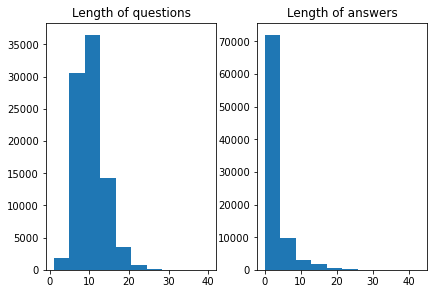

In [19]:
questions_train_raw, questions_valid_raw, answers_train_raw, answers_valid_raw = questions_answers(source_name=source_name)
show_lengths(questions_train_raw, questions_valid_raw, answers_train_raw, answers_valid_raw)

### Filter data

In [20]:
temp = [pair for pair in zip(questions_train_raw, answers_train_raw) if len(pair[1])>3]
questions_train_filt, answers_train_filt = map(list, zip(*temp))
temp = [pair for pair in zip(questions_valid_raw, answers_valid_raw) if len(pair[1])>3]
questions_valid_filt, answers_valid_filt = map(list, zip(*temp))
print(f"{len(questions_train_filt)} training questions and {len(questions_valid_filt)} valid questions remain.")

16845 training questions and 5095 valid questions remain.


### Create vocabularies

In [21]:
vQ = Vocab("Questions")
for sequence in [["<SOS>", "<EOS>"]] + questions_train_filt + questions_valid_filt:
    for token in sequence:
        vQ.indexWord(token)
vA = Vocab("Answers")
for sequence in [["<SOS>", "<EOS>"]] + answers_train_filt + answers_valid_filt:
    for token in sequence:
        vA.indexWord(token)
print(f"The source vocabulary contains {len(vQ.words)} and the target vocabulary contains {len(vA.words)} words.")

The source vocabulary contains 13715 and the target vocabulary contains 17991 words.


### Create vectors

In [22]:
questions_train = tokenize_questions(questions_train_filt, vQ)
answers_train = tokenize_answers(answers_train_filt, vA)
questions_valid = tokenize_questions(questions_valid_filt, vQ)
answers_valid = tokenize_answers(answers_valid_filt, vA)

### Create model

In [23]:
input_size = len(vQ.words)
hidden_size = 100
output_size = len(vA.words) 

dropout_E=0.0
dropout_D=0.0
teacher_forcing_ratio=0.0


model = Seq2Seq(input_size, hidden_size, output_size, vQ, vA, dropout_E, dropout_D, teacher_forcing_ratio)

### Utilize pretrained embeddings

In [24]:
w2v = pretrained_w2v(init=False)
model = pretrain(model, vQ, vA, w2v)

For 2719 of 13715 words an entry has been found in the brown corpus.
For 3000 of 17991 words an entry has been found in the brown corpus.


#### => most_similar is not working after adding vector in gensim

### Train model

In [ ]:
epochs = 100
batch_size = 4
print_each = 1
lr = 0.01
weight_decay = 0
version = str(hidden_size)
train(epochs, batch_size, print_each, lr, weight_decay, model, version, questions_train, answers_train, questions_valid, answers_valid, vQ, vA)

Loading from checkpoint: 'model_100.pt'
Computing on cpu.


In [ ]:
model.eval()
for i in [1,2,200,-2,-1]:
    answer(model, questions_train[i].view(1,-1), vA, answers_train[i], vQ, 5)

In [ ]:
answers_train

In [ ]:
import random
a=random.randint(0,3)
print(a)

In [ ]:
hallo